In [16]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
import io
from torchmetrics import PeakSignalNoiseRatio as PSNR, StructuralSimilarityIndexMeasure as SSIM
from piq import LPIPS
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from tqdm import tqdm 
from skimage.metrics import structural_similarity as ssim
import lpips 
from torch.optim.lr_scheduler import LambdaLR
from torchvision.utils import save_image
import random

## Preprocessing

In [17]:
dataset_path1 = '/home/gsalsabil2/deep_learning/augment_images'
train_path = f'{dataset_path1}/train'
val_path = f'{dataset_path1}/val'
test_path = f'{dataset_path1}/test'

In [18]:
class CleanDataset(Dataset):
    def __init__(self, root_dir, target_transform=None):
        self.root_dir = root_dir
        self.target_transform = target_transform
        self.low_dir = os.path.join(root_dir, "low")
        self.high_dir = os.path.join(root_dir, "high")
        self.image_names = sorted(os.listdir(self.low_dir))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        low_img_path = os.path.join(self.low_dir, self.image_names[idx])
        high_img_path = os.path.join(self.high_dir, self.image_names[idx])

        low_img = Image.open(low_img_path).convert("RGB")
        high_img = Image.open(high_img_path).convert("RGB")

        if self.target_transform:
            low_img = self.target_transform(low_img)
            high_img = self.target_transform(high_img)
            
            
        low_filename = os.path.basename(low_img_path)
        high_filename = os.path.basename(high_img_path)
        
        return low_img, high_img, low_filename, high_filename

target_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_dataset = CleanDataset(
    root_dir=train_path, 
    target_transform = target_transform
)

val_dataset = CleanDataset(
    root_dir=val_path,
    target_transform = target_transform
)

test_dataset = CleanDataset(root_dir=test_path, target_transform = target_transform)

In [19]:
batch_size = 8
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True   # Speeds up transfer to GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,         # No need for validation
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,       # Often use batch_size=1 for testing
    shuffle=False,
    num_workers=1
)

In [20]:
def show_true_images(low_batch, high_batch, n=4):

    """
    Shows EXACTLY what's in your dataset with correct color handling.
    Works for both normalized and unnormalized images.
    """

    plt.figure(figsize=(18, 8))

    for i in range(min(n, len(low_batch))):
        # --- Low-light ---
        plt.subplot(2, n, i+1)
        low_img = low_batch[i].permute(1, 2, 0).numpy()

        # Handle normalization if present
        if low_img.min() < 0:  # Likely normalized
            low_img = (low_img * 0.5 + 0.5)  # Reverse imagenet norm

        # Ensure proper image range
        low_img = np.clip(low_img, 0, 1)
        plt.imshow(low_img)
        plt.title(f"Low")
        plt.axis('off')

        # --- Normal-light ---
        plt.subplot(2, n, n+i+1)
        high_img = high_batch[i].permute(1, 2, 0).numpy()

        if high_img.min() < 0:  # Likely normalized
            high_img = (high_img * 0.5 + 0.5)

        high_img = np.clip(high_img, 0, 1)
        plt.imshow(high_img)
        plt.title(f"High")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Low resolution file name: ['567.png', '617.png', '765.png', '508.png', '203.png', '195.png', '607.png', '690.png']
High resolution file name: ['567.png', '617.png', '765.png', '508.png', '203.png', '195.png', '607.png', '690.png']


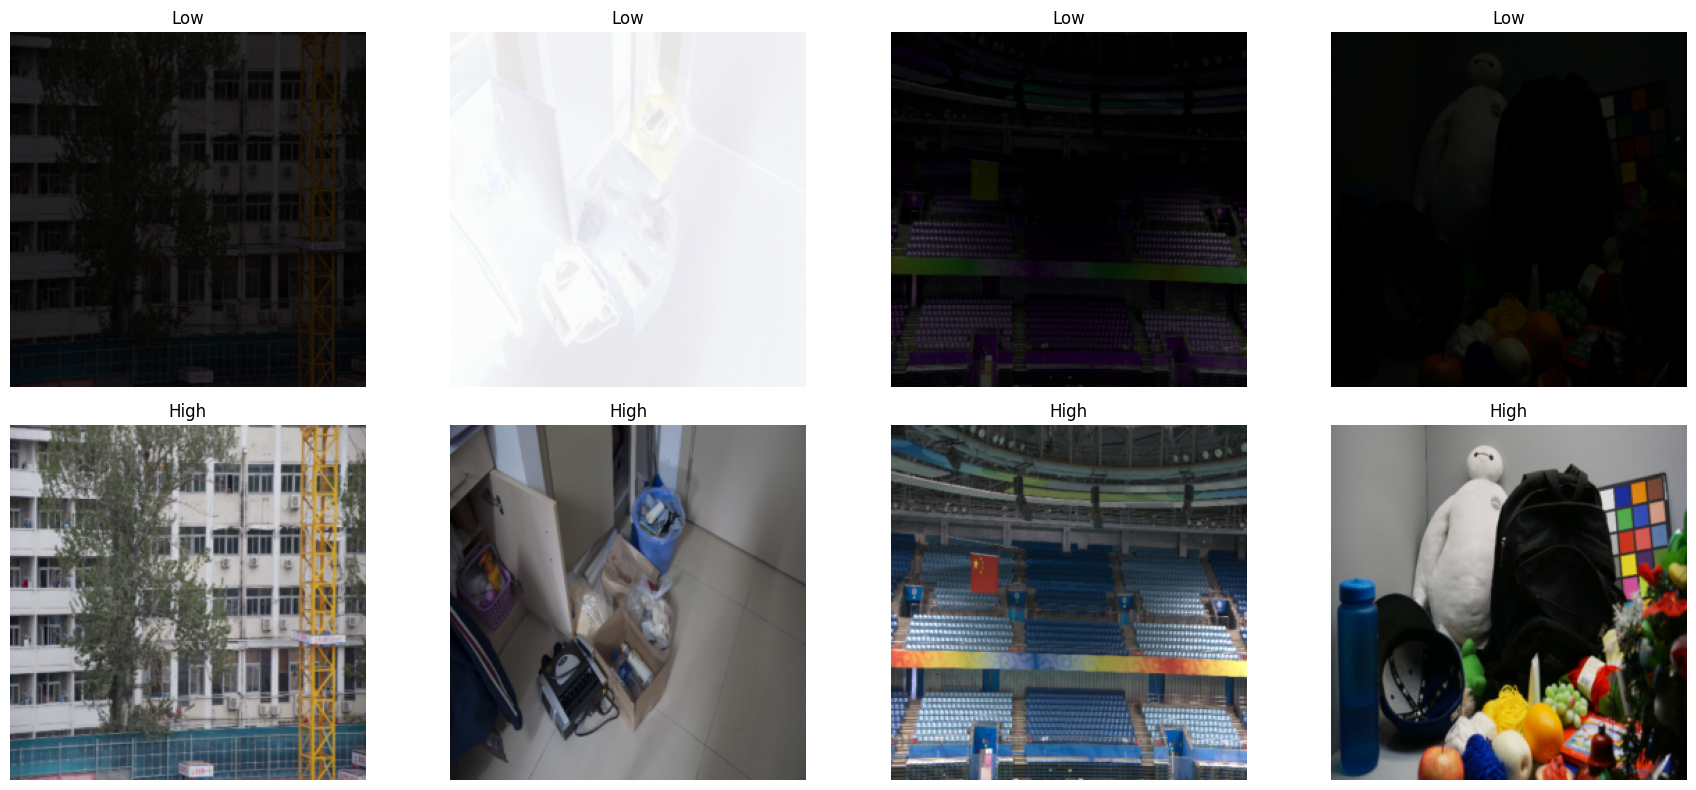

In [21]:
low, high, low_filename, high_filename = next(iter(train_loader))
print("Low resolution file name:", low_filename)
print("High resolution file name:", high_filename)
show_true_images(low, high)

## Model Architecture

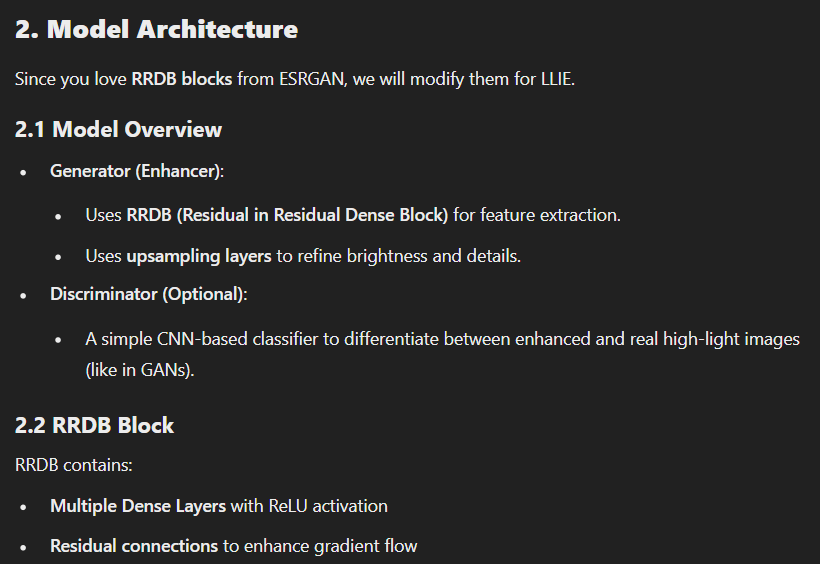

In [22]:
## RRDB blocks architecture derived from the paper ESRGAN..

class ResidualDenseBlock(nn.Module):
    def __init__(self, in_channels=64, growth_rate=32):
        super(ResidualDenseBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels + growth_rate, growth_rate, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels + 2 * growth_rate, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        out1 = torch.relu(self.conv1(x))
        out2 = torch.relu(self.conv2(torch.cat([x, out1], dim=1)))
        out3 = self.conv3(torch.cat([x, out1, out2], dim=1))
        return x + out3

class RRDB(nn.Module):
    def __init__(self, in_channels=64, beta=0.2):  
        super(RRDB, self).__init__()
        self.rdb1 = ResidualDenseBlock(in_channels)
        self.rdb2 = ResidualDenseBlock(in_channels)
        self.rdb3 = ResidualDenseBlock(in_channels)
        self.beta = beta  # Scaling factor for residual

    def forward(self, x):
        residual = self.rdb3(self.rdb2(self.rdb1(x)))
        return x + self.beta * residual  # Scaled residual for stability

In [23]:
class Generator(nn.Module):
    def __init__(self, num_rrdb=6):
        super(Generator, self).__init__()

        # Initial feature extraction
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # RRDB Blocks
        self.rrdb_blocks = nn.Sequential(*[RRDB(64) for _ in range(num_rrdb)])

        # Global Residual Path (helps learn overall brightness correction)
        self.global_residual = nn.Conv2d(3, 3, kernel_size=3, padding=1)

        # Final convolution layers for reconstruction
        self.final_conv = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=3, padding=1)
        )

    def forward(self, x):
        initial_features = self.initial_conv(x)
        enhanced_features = self.rrdb_blocks(initial_features)
        reconstructed = self.final_conv(enhanced_features)
        
        # Adding the global residual path
        output = reconstructed + self.global_residual(x)
        
        return torch.sigmoid(output)  # Normalize output to [0,1]

In [24]:
'''  Use a Discriminator (GAN Approach)
        This makes the enhanced image look more realistic by forcing the Generator to fool a Discriminator.
        USES PatchGANDiscriminator idea as the Discriminator'''

class PatchGANDiscriminator(nn.Module):
    def __init__(self, in_channels=3, num_filters=64, num_layers=3):
        super(PatchGANDiscriminator, self).__init__()
        
        # Initial convolutional layer
        layers = [
            nn.Conv2d(in_channels, num_filters, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        
        # Intermediate convolutional layers
        for i in range(1, num_layers):
            layers += [
                nn.Conv2d(num_filters * (2 ** (i - 1)), num_filters * (2 ** i), kernel_size=4, stride=2, padding=1),
                nn.InstanceNorm2d(num_filters * (2 ** i)),
                nn.LeakyReLU(0.2, inplace=True)
            ]
        
        # Final convolutional layer
        layers += [
            nn.Conv2d(num_filters * (2 ** (num_layers - 1)), 1, kernel_size=4, stride=1, padding=1)
        ]
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)  # Output shape: [batch_size, 1, H, W]

In [25]:
## Loss Functions

# L1 Loss (Pixel-Level Difference)
class GANLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.BCEWithLogitsLoss()

    def forward(self, pred, target_is_real):
        target = torch.ones_like(pred) if target_is_real else torch.zeros_like(pred)
        return self.loss(pred, target)

# Perceptual Loss using VGG-19 Features
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg19(pretrained=True).features[:16]  # Use first few layers
        for param in vgg.parameters():
            param.requires_grad = False  # Freeze VGG model
        self.vgg = vgg.eval()
        self.criterion = nn.L1Loss()

    def forward(self, x, y):
        x_features = self.vgg(x)
        y_features = self.vgg(y)
        return self.criterion(x_features, y_features)

In [26]:
## Common evaluating Metrics
device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')

# Initialize metrics
psnr = PSNR().to(device)
ssim = SSIM().to(device)
lpips = LPIPS(replace_pooling=True).to(device)

# Initialize models and losses
generator = Generator().to(device)
discriminator = PatchGANDiscriminator().to(device)
opt_g = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
opt_d = optim.Adam(discriminator.parameters(), lr = 4e-4, betas=(0.5, 0.999))

# Losses
criterion_gan = GANLoss()
criterion_l1 = nn.L1Loss()
criterion_perceptual = PerceptualLoss().to(device)

/home/gsalsabil2/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
/home/gsalsabil2/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(
/home/gsalsabil2/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gsalsabil2/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated

In [27]:
def validate(generator, val_loader, epoch):
    generator.eval()
    val_metrics = {'psnr': 0, 'ssim': 0, 'lpips': 0, 'val_loss': 0}

    with torch.no_grad():
        for low, high, *_ in tqdm(val_loader, desc=f'Validation Epoch {epoch}', leave=False):
            low, high = low.to(device), high.to(device)
            fake = generator(low)

            # Validation loss (L1 + perceptual)
            loss = (10 * F.l1_loss(fake, high) + 0.1 * criterion_perceptual(fake, high)).item()
            
            # Update metrics
            val_metrics['val_loss'] += loss
            val_metrics['psnr'] += psnr(fake, high)
            val_metrics['ssim'] += ssim(fake, high)
            val_metrics['lpips'] += lpips(fake, high)

    for k in val_metrics:
        val_metrics[k] /= len(val_loader)
    return val_metrics

Source: https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan_gp/wgan_gp.py

In [28]:
def compute_gradient_penalty(disc, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = disc(interpolates)
    fake = torch.ones_like(d_interpolates)
    
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [29]:
def train_gan(
    generator,
    discriminator,
    train_loader,
    val_loader,
    criterion_gan,
    criterion_l1,
    criterion_perceptual,
    opt_g,
    opt_d,
    epochs,
    device,
    save_dir="RRDB_SE_CHECKPOINTS"
):
    os.makedirs(save_dir, exist_ok=True)
    best_ssim = 0
    best_psnr=0
    best_lpips=100

    for epoch in range(epochs):
        # Training phase
        generator.train()
        discriminator.train()

        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        for low, high, *_ in train_bar:
            low, high = low.to(device), high.to(device)

            # --- Discriminator Update ---
            opt_d.zero_grad()

            # Real images
            real_pred = discriminator(high)
            real_loss = criterion_gan(real_pred, True)

            # Fake images
            fake = generator(low).detach()
            fake_pred = discriminator(fake)
            fake_loss = criterion_gan(fake_pred, False)
            
            gp = compute_gradient_penalty(discriminator, high.data, fake.data)
            d_loss = (real_loss + fake_loss) / 2+ 10*gp
            d_loss.backward()
            opt_d.step()

            # --- Generator Update ---
            opt_g.zero_grad()
            fake = generator(low)
            g_gan_loss = criterion_gan(discriminator(fake), True)
            g_l1_loss = criterion_l1(fake, high) * 10
            g_perc_loss = criterion_perceptual(fake, high) * 0.1
            g_loss = g_gan_loss + g_l1_loss + g_perc_loss
            g_loss.backward()
            opt_g.step()

            # Update progress bar
            train_bar.set_postfix({
                'D_loss': f'{d_loss.item():.3f}',
                'G_loss': f'{g_loss.item():.3f}',
                'L1': f'{g_l1_loss.item():.3f}'
            })

        # Validation phase
        val_metrics = validate(generator, val_loader, epoch+1)

        # Print metrics
        print(f"\nValidation @ Epoch {epoch+1}:")
        print(f"PSNR: {val_metrics['psnr']:.2f} dB | SSIM: {val_metrics['ssim']:.4f} | LPIPS: {val_metrics['lpips']:.4f}")

        # Save checkpoint
        torch.save({
            'epoch': epoch+1,
            'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict(),
            'opt_g': opt_g.state_dict(),
            'opt_d': opt_d.state_dict(),
            'metrics': val_metrics
        }, os.path.join(save_dir, f'epoch_{epoch+1}.pth'))

        # Save best model
        if (val_metrics['psnr'] > best_psnr) and (val_metrics['lpips'] < best_lpips) and (val_metrics['ssim'] > best_ssim):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_model.pth'))
            print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | LPIPS: {val_metrics['lpips']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")

        if (val_metrics['lpips'] < best_lpips) and (val_metrics['ssim'] > best_ssim):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_lpips_ssim.pth'))
            print(f"🔥 New best model (LPIPS: {val_metrics['lpips']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")

        if (val_metrics['psnr'] > best_psnr) and (val_metrics['ssim'] > best_ssim):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr_ssim.pth'))
            print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")

        if (val_metrics['psnr'] > best_psnr) and (val_metrics['lpips'] < best_lpips):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr_lpips.pth'))
            print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | LPIPS: {val_metrics['lpips']:.4f}) saved!")
                
        if val_metrics['ssim'] > best_ssim:
            best_ssim = val_metrics['ssim']
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_ssim.pth'))
            print(f"🔥 New best model (SSIM: {best_ssim:.4f}) saved!")
                    
        if val_metrics['psnr'] > best_psnr:
            best_psnr = val_metrics['psnr']
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr.pth'))
            print(f"🔥 New best model (PSNR: {best_psnr:.4f}) saved!")

        if val_metrics['lpips'] < best_lpips:
            best_lpips = val_metrics['lpips']
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_lpips.pth'))
            print(f"🔥 New best model (LPIPS: {best_lpips:.4f}) saved!")

        # Sample images
        if (epoch+1) % 5 == 0:
            with torch.no_grad():
                fake = generator(low[:3])  # First 3 samples
                save_image(
                    torch.cat([low[:3], fake, high[:3]], 0),
                    os.path.join(save_dir, f'sample_epoch_{epoch+1}.png'),
                    nrow=3,
                    normalize=True
                )


In [30]:
train_gan(
    generator=generator,
    discriminator=discriminator,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion_gan=criterion_gan,
    criterion_l1=criterion_l1,
    criterion_perceptual=criterion_perceptual,
    opt_g=opt_g,
    opt_d=opt_d,
    epochs=200,
    device=device
)

Epoch 1/200: 100%|██████████| 49/49 [00:27<00:00,  1.81it/s, D_loss=260.562, G_loss=2.591, L1=1.809]  



Validation @ Epoch 1:
PSNR: 15.13 dB | SSIM: 0.6193 | LPIPS: 0.4739
🔥 New best model (PSNR: 15.1290 | LPIPS: 0.4739 | SSIM: 0.6193) saved!
🔥 New best model (LPIPS: 0.4739 | SSIM: 0.6193) saved!
🔥 New best model (PSNR: 15.1290 | SSIM: 0.6193) saved!
🔥 New best model (PSNR: 15.1290 | LPIPS: 0.4739) saved!
🔥 New best model (SSIM: 0.6193) saved!
🔥 New best model (PSNR: 15.1290) saved!
🔥 New best model (LPIPS: 0.4739) saved!


Epoch 2/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=11.693, G_loss=2.029, L1=1.251] 



Validation @ Epoch 2:
PSNR: 15.46 dB | SSIM: 0.6477 | LPIPS: 0.4264
🔥 New best model (PSNR: 15.4568 | LPIPS: 0.4264 | SSIM: 0.6477) saved!
🔥 New best model (LPIPS: 0.4264 | SSIM: 0.6477) saved!
🔥 New best model (PSNR: 15.4568 | SSIM: 0.6477) saved!
🔥 New best model (PSNR: 15.4568 | LPIPS: 0.4264) saved!
🔥 New best model (SSIM: 0.6477) saved!
🔥 New best model (PSNR: 15.4568) saved!
🔥 New best model (LPIPS: 0.4264) saved!


Epoch 3/200: 100%|██████████| 49/49 [00:27<00:00,  1.75it/s, D_loss=285.132, G_loss=1.978, L1=1.185]



Validation @ Epoch 3:
PSNR: 15.38 dB | SSIM: 0.6624 | LPIPS: 0.4144
🔥 New best model (LPIPS: 0.4144 | SSIM: 0.6624) saved!
🔥 New best model (SSIM: 0.6624) saved!
🔥 New best model (LPIPS: 0.4144) saved!


Epoch 4/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=25.179, G_loss=2.620, L1=1.844] 



Validation @ Epoch 4:
PSNR: 15.76 dB | SSIM: 0.6840 | LPIPS: 0.3658
🔥 New best model (PSNR: 15.7604 | LPIPS: 0.3658 | SSIM: 0.6840) saved!
🔥 New best model (LPIPS: 0.3658 | SSIM: 0.6840) saved!
🔥 New best model (PSNR: 15.7604 | SSIM: 0.6840) saved!
🔥 New best model (PSNR: 15.7604 | LPIPS: 0.3658) saved!
🔥 New best model (SSIM: 0.6840) saved!
🔥 New best model (PSNR: 15.7604) saved!
🔥 New best model (LPIPS: 0.3658) saved!


Epoch 5/200: 100%|██████████| 49/49 [00:28<00:00,  1.73it/s, D_loss=40.036, G_loss=2.090, L1=1.342]



Validation @ Epoch 5:
PSNR: 15.94 dB | SSIM: 0.7166 | LPIPS: 0.3330
🔥 New best model (PSNR: 15.9388 | LPIPS: 0.3330 | SSIM: 0.7166) saved!
🔥 New best model (LPIPS: 0.3330 | SSIM: 0.7166) saved!
🔥 New best model (PSNR: 15.9388 | SSIM: 0.7166) saved!
🔥 New best model (PSNR: 15.9388 | LPIPS: 0.3330) saved!
🔥 New best model (SSIM: 0.7166) saved!
🔥 New best model (PSNR: 15.9388) saved!
🔥 New best model (LPIPS: 0.3330) saved!


Epoch 6/200: 100%|██████████| 49/49 [00:28<00:00,  1.73it/s, D_loss=2.989, G_loss=2.315, L1=1.533]  



Validation @ Epoch 6:
PSNR: 15.90 dB | SSIM: 0.7270 | LPIPS: 0.3323
🔥 New best model (LPIPS: 0.3323 | SSIM: 0.7270) saved!
🔥 New best model (SSIM: 0.7270) saved!
🔥 New best model (LPIPS: 0.3323) saved!


Epoch 7/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=3.614, G_loss=2.090, L1=1.338] 



Validation @ Epoch 7:
PSNR: 15.61 dB | SSIM: 0.7217 | LPIPS: 0.3319
🔥 New best model (LPIPS: 0.3319) saved!


Epoch 8/200: 100%|██████████| 49/49 [00:28<00:00,  1.72it/s, D_loss=9.870, G_loss=2.230, L1=1.461] 



Validation @ Epoch 8:
PSNR: 15.94 dB | SSIM: 0.7359 | LPIPS: 0.3491
🔥 New best model (SSIM: 0.7359) saved!


Epoch 9/200: 100%|██████████| 49/49 [00:28<00:00,  1.73it/s, D_loss=1.474, G_loss=1.643, L1=0.899] 



Validation @ Epoch 9:
PSNR: 16.21 dB | SSIM: 0.7595 | LPIPS: 0.3089
🔥 New best model (PSNR: 16.2130 | LPIPS: 0.3089 | SSIM: 0.7595) saved!
🔥 New best model (LPIPS: 0.3089 | SSIM: 0.7595) saved!
🔥 New best model (PSNR: 16.2130 | SSIM: 0.7595) saved!
🔥 New best model (PSNR: 16.2130 | LPIPS: 0.3089) saved!
🔥 New best model (SSIM: 0.7595) saved!
🔥 New best model (PSNR: 16.2130) saved!
🔥 New best model (LPIPS: 0.3089) saved!


Epoch 10/200: 100%|██████████| 49/49 [00:28<00:00,  1.73it/s, D_loss=5.782, G_loss=2.227, L1=1.451] 



Validation @ Epoch 10:
PSNR: 16.27 dB | SSIM: 0.7553 | LPIPS: 0.3106
🔥 New best model (PSNR: 16.2695) saved!


Epoch 11/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=13.815, G_loss=2.214, L1=1.440]



Validation @ Epoch 11:
PSNR: 16.28 dB | SSIM: 0.7606 | LPIPS: 0.3183
🔥 New best model (PSNR: 16.2790 | SSIM: 0.7606) saved!
🔥 New best model (SSIM: 0.7606) saved!
🔥 New best model (PSNR: 16.2790) saved!


Epoch 12/200: 100%|██████████| 49/49 [00:28<00:00,  1.73it/s, D_loss=1.219, G_loss=1.910, L1=1.163] 



Validation @ Epoch 12:
PSNR: 16.34 dB | SSIM: 0.7612 | LPIPS: 0.3073
🔥 New best model (PSNR: 16.3353 | LPIPS: 0.3073 | SSIM: 0.7612) saved!
🔥 New best model (LPIPS: 0.3073 | SSIM: 0.7612) saved!
🔥 New best model (PSNR: 16.3353 | SSIM: 0.7612) saved!
🔥 New best model (PSNR: 16.3353 | LPIPS: 0.3073) saved!
🔥 New best model (SSIM: 0.7612) saved!
🔥 New best model (PSNR: 16.3353) saved!
🔥 New best model (LPIPS: 0.3073) saved!


Epoch 13/200: 100%|██████████| 49/49 [00:28<00:00,  1.72it/s, D_loss=3.207, G_loss=2.034, L1=1.285] 



Validation @ Epoch 13:
PSNR: 16.41 dB | SSIM: 0.7575 | LPIPS: 0.3151
🔥 New best model (PSNR: 16.4118) saved!


Epoch 14/200: 100%|██████████| 49/49 [00:28<00:00,  1.73it/s, D_loss=1.799, G_loss=2.538, L1=1.808] 



Validation @ Epoch 14:
PSNR: 16.04 dB | SSIM: 0.7636 | LPIPS: 0.3007
🔥 New best model (LPIPS: 0.3007 | SSIM: 0.7636) saved!
🔥 New best model (SSIM: 0.7636) saved!
🔥 New best model (LPIPS: 0.3007) saved!


Epoch 15/200: 100%|██████████| 49/49 [00:28<00:00,  1.73it/s, D_loss=60.177, G_loss=1.928, L1=1.180]



Validation @ Epoch 15:
PSNR: 17.01 dB | SSIM: 0.7815 | LPIPS: 0.2856
🔥 New best model (PSNR: 17.0147 | LPIPS: 0.2856 | SSIM: 0.7815) saved!
🔥 New best model (LPIPS: 0.2856 | SSIM: 0.7815) saved!
🔥 New best model (PSNR: 17.0147 | SSIM: 0.7815) saved!
🔥 New best model (PSNR: 17.0147 | LPIPS: 0.2856) saved!
🔥 New best model (SSIM: 0.7815) saved!
🔥 New best model (PSNR: 17.0147) saved!
🔥 New best model (LPIPS: 0.2856) saved!


Epoch 16/200: 100%|██████████| 49/49 [00:28<00:00,  1.72it/s, D_loss=3.678, G_loss=1.907, L1=1.193]  



Validation @ Epoch 16:
PSNR: 16.36 dB | SSIM: 0.7735 | LPIPS: 0.2940


Epoch 17/200: 100%|██████████| 49/49 [00:28<00:00,  1.73it/s, D_loss=0.815, G_loss=1.869, L1=1.118] 



Validation @ Epoch 17:
PSNR: 15.68 dB | SSIM: 0.7616 | LPIPS: 0.2875


Epoch 18/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.798, G_loss=1.742, L1=0.994] 



Validation @ Epoch 18:
PSNR: 16.11 dB | SSIM: 0.7677 | LPIPS: 0.2905


Epoch 19/200: 100%|██████████| 49/49 [00:28<00:00,  1.73it/s, D_loss=0.842, G_loss=1.985, L1=1.211] 



Validation @ Epoch 19:
PSNR: 16.66 dB | SSIM: 0.7668 | LPIPS: 0.2823
🔥 New best model (LPIPS: 0.2823) saved!


Epoch 20/200: 100%|██████████| 49/49 [00:28<00:00,  1.72it/s, D_loss=6.990, G_loss=2.088, L1=1.346] 



Validation @ Epoch 20:
PSNR: 16.40 dB | SSIM: 0.7826 | LPIPS: 0.2899
🔥 New best model (SSIM: 0.7826) saved!


Epoch 21/200: 100%|██████████| 49/49 [00:28<00:00,  1.73it/s, D_loss=1.347, G_loss=1.825, L1=1.076] 



Validation @ Epoch 21:
PSNR: 16.57 dB | SSIM: 0.7885 | LPIPS: 0.2740
🔥 New best model (LPIPS: 0.2740 | SSIM: 0.7885) saved!
🔥 New best model (SSIM: 0.7885) saved!
🔥 New best model (LPIPS: 0.2740) saved!


Epoch 22/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.800, G_loss=1.889, L1=1.161] 



Validation @ Epoch 22:
PSNR: 16.61 dB | SSIM: 0.7925 | LPIPS: 0.2671
🔥 New best model (LPIPS: 0.2671 | SSIM: 0.7925) saved!
🔥 New best model (SSIM: 0.7925) saved!
🔥 New best model (LPIPS: 0.2671) saved!


Epoch 23/200: 100%|██████████| 49/49 [00:28<00:00,  1.73it/s, D_loss=0.893, G_loss=2.708, L1=1.963] 



Validation @ Epoch 23:
PSNR: 16.38 dB | SSIM: 0.7857 | LPIPS: 0.2889


Epoch 24/200: 100%|██████████| 49/49 [00:28<00:00,  1.73it/s, D_loss=1.345, G_loss=2.005, L1=1.255] 



Validation @ Epoch 24:
PSNR: 17.04 dB | SSIM: 0.7994 | LPIPS: 0.2641
🔥 New best model (PSNR: 17.0408 | LPIPS: 0.2641 | SSIM: 0.7994) saved!
🔥 New best model (LPIPS: 0.2641 | SSIM: 0.7994) saved!
🔥 New best model (PSNR: 17.0408 | SSIM: 0.7994) saved!
🔥 New best model (PSNR: 17.0408 | LPIPS: 0.2641) saved!
🔥 New best model (SSIM: 0.7994) saved!
🔥 New best model (PSNR: 17.0408) saved!
🔥 New best model (LPIPS: 0.2641) saved!


Epoch 25/200: 100%|██████████| 49/49 [00:28<00:00,  1.72it/s, D_loss=2.017, G_loss=2.161, L1=1.419]



Validation @ Epoch 25:
PSNR: 15.34 dB | SSIM: 0.7387 | LPIPS: 0.3410


Epoch 26/200: 100%|██████████| 49/49 [00:28<00:00,  1.72it/s, D_loss=1.154, G_loss=2.109, L1=1.347]



Validation @ Epoch 26:
PSNR: 16.97 dB | SSIM: 0.8072 | LPIPS: 0.2573
🔥 New best model (LPIPS: 0.2573 | SSIM: 0.8072) saved!
🔥 New best model (SSIM: 0.8072) saved!
🔥 New best model (LPIPS: 0.2573) saved!


Epoch 27/200: 100%|██████████| 49/49 [00:28<00:00,  1.72it/s, D_loss=0.897, G_loss=1.782, L1=1.043] 



Validation @ Epoch 27:
PSNR: 16.73 dB | SSIM: 0.7955 | LPIPS: 0.2623


Epoch 28/200: 100%|██████████| 49/49 [00:28<00:00,  1.73it/s, D_loss=0.959, G_loss=1.768, L1=1.034]



Validation @ Epoch 28:
PSNR: 17.16 dB | SSIM: 0.8025 | LPIPS: 0.2578
🔥 New best model (PSNR: 17.1567) saved!


Epoch 29/200: 100%|██████████| 49/49 [00:28<00:00,  1.72it/s, D_loss=0.892, G_loss=1.649, L1=0.913]



Validation @ Epoch 29:
PSNR: 17.10 dB | SSIM: 0.8051 | LPIPS: 0.2572
🔥 New best model (LPIPS: 0.2572) saved!


Epoch 30/200: 100%|██████████| 49/49 [00:28<00:00,  1.72it/s, D_loss=1.094, G_loss=1.557, L1=0.812]



Validation @ Epoch 30:
PSNR: 17.02 dB | SSIM: 0.8065 | LPIPS: 0.2532
🔥 New best model (LPIPS: 0.2532) saved!


Epoch 31/200: 100%|██████████| 49/49 [00:28<00:00,  1.73it/s, D_loss=1.136, G_loss=1.830, L1=1.091]



Validation @ Epoch 31:
PSNR: 16.21 dB | SSIM: 0.7864 | LPIPS: 0.2654


Epoch 32/200: 100%|██████████| 49/49 [00:28<00:00,  1.72it/s, D_loss=0.752, G_loss=1.553, L1=0.812]



Validation @ Epoch 32:
PSNR: 16.67 dB | SSIM: 0.7935 | LPIPS: 0.2659


Epoch 33/200: 100%|██████████| 49/49 [00:28<00:00,  1.73it/s, D_loss=0.858, G_loss=1.685, L1=0.950]



Validation @ Epoch 33:
PSNR: 17.00 dB | SSIM: 0.8063 | LPIPS: 0.2519
🔥 New best model (LPIPS: 0.2519) saved!


Epoch 34/200: 100%|██████████| 49/49 [00:28<00:00,  1.73it/s, D_loss=1.715, G_loss=1.283, L1=0.548]



Validation @ Epoch 34:
PSNR: 16.91 dB | SSIM: 0.8124 | LPIPS: 0.2549
🔥 New best model (SSIM: 0.8124) saved!


Epoch 35/200: 100%|██████████| 49/49 [00:28<00:00,  1.72it/s, D_loss=0.883, G_loss=1.673, L1=0.943]



Validation @ Epoch 35:
PSNR: 17.24 dB | SSIM: 0.8114 | LPIPS: 0.2463
🔥 New best model (PSNR: 17.2402 | LPIPS: 0.2463) saved!
🔥 New best model (PSNR: 17.2402) saved!
🔥 New best model (LPIPS: 0.2463) saved!


Epoch 36/200: 100%|██████████| 49/49 [00:28<00:00,  1.72it/s, D_loss=0.850, G_loss=2.017, L1=1.280] 



Validation @ Epoch 36:
PSNR: 16.25 dB | SSIM: 0.7900 | LPIPS: 0.2601


Epoch 37/200: 100%|██████████| 49/49 [00:28<00:00,  1.73it/s, D_loss=0.883, G_loss=2.085, L1=1.352]



Validation @ Epoch 37:
PSNR: 17.00 dB | SSIM: 0.8129 | LPIPS: 0.2470
🔥 New best model (SSIM: 0.8129) saved!


Epoch 38/200: 100%|██████████| 49/49 [00:28<00:00,  1.73it/s, D_loss=0.820, G_loss=1.741, L1=0.993]



Validation @ Epoch 38:
PSNR: 16.83 dB | SSIM: 0.8128 | LPIPS: 0.2591


Epoch 39/200: 100%|██████████| 49/49 [00:28<00:00,  1.72it/s, D_loss=0.745, G_loss=2.467, L1=1.719]



Validation @ Epoch 39:
PSNR: 16.39 dB | SSIM: 0.8034 | LPIPS: 0.2597


Epoch 40/200: 100%|██████████| 49/49 [00:28<00:00,  1.72it/s, D_loss=0.788, G_loss=1.897, L1=1.159]



Validation @ Epoch 40:
PSNR: 17.19 dB | SSIM: 0.8201 | LPIPS: 0.2385
🔥 New best model (LPIPS: 0.2385 | SSIM: 0.8201) saved!
🔥 New best model (SSIM: 0.8201) saved!
🔥 New best model (LPIPS: 0.2385) saved!


Epoch 41/200: 100%|██████████| 49/49 [00:28<00:00,  1.72it/s, D_loss=0.904, G_loss=1.641, L1=0.905]



Validation @ Epoch 41:
PSNR: 16.43 dB | SSIM: 0.8069 | LPIPS: 0.2531


Epoch 42/200: 100%|██████████| 49/49 [00:28<00:00,  1.73it/s, D_loss=0.780, G_loss=2.109, L1=1.380]



Validation @ Epoch 42:
PSNR: 16.84 dB | SSIM: 0.8072 | LPIPS: 0.2514


Epoch 43/200: 100%|██████████| 49/49 [00:28<00:00,  1.73it/s, D_loss=0.888, G_loss=1.775, L1=1.040]



Validation @ Epoch 43:
PSNR: 16.80 dB | SSIM: 0.8085 | LPIPS: 0.2652


Epoch 44/200: 100%|██████████| 49/49 [00:28<00:00,  1.72it/s, D_loss=0.814, G_loss=2.033, L1=1.283]



Validation @ Epoch 44:
PSNR: 16.73 dB | SSIM: 0.8044 | LPIPS: 0.2579


Epoch 45/200: 100%|██████████| 49/49 [00:28<00:00,  1.72it/s, D_loss=0.744, G_loss=1.892, L1=1.155]



Validation @ Epoch 45:
PSNR: 16.61 dB | SSIM: 0.8009 | LPIPS: 0.2436


Epoch 46/200: 100%|██████████| 49/49 [00:28<00:00,  1.72it/s, D_loss=0.810, G_loss=1.596, L1=0.865]



Validation @ Epoch 46:
PSNR: 16.41 dB | SSIM: 0.7859 | LPIPS: 0.2769


Epoch 47/200: 100%|██████████| 49/49 [00:28<00:00,  1.73it/s, D_loss=0.812, G_loss=2.060, L1=1.328]



Validation @ Epoch 47:
PSNR: 16.70 dB | SSIM: 0.8118 | LPIPS: 0.2404


Epoch 48/200: 100%|██████████| 49/49 [00:28<00:00,  1.72it/s, D_loss=0.772, G_loss=1.678, L1=0.942]



Validation @ Epoch 48:
PSNR: 16.74 dB | SSIM: 0.8084 | LPIPS: 0.2579


Epoch 49/200: 100%|██████████| 49/49 [00:28<00:00,  1.72it/s, D_loss=0.952, G_loss=1.932, L1=1.188]



Validation @ Epoch 49:
PSNR: 16.83 dB | SSIM: 0.8126 | LPIPS: 0.2506


Epoch 50/200: 100%|██████████| 49/49 [00:28<00:00,  1.73it/s, D_loss=1.159, G_loss=1.782, L1=1.047]



Validation @ Epoch 50:
PSNR: 17.06 dB | SSIM: 0.8205 | LPIPS: 0.2392
🔥 New best model (SSIM: 0.8205) saved!


Epoch 51/200: 100%|██████████| 49/49 [00:28<00:00,  1.72it/s, D_loss=0.933, G_loss=1.983, L1=1.242] 



Validation @ Epoch 51:
PSNR: 16.97 dB | SSIM: 0.8194 | LPIPS: 0.2442


Epoch 52/200: 100%|██████████| 49/49 [00:28<00:00,  1.73it/s, D_loss=0.773, G_loss=2.202, L1=1.454]



Validation @ Epoch 52:
PSNR: 16.90 dB | SSIM: 0.8068 | LPIPS: 0.2569


Epoch 53/200: 100%|██████████| 49/49 [00:28<00:00,  1.73it/s, D_loss=1.589, G_loss=1.578, L1=0.848]



Validation @ Epoch 53:
PSNR: 16.95 dB | SSIM: 0.8215 | LPIPS: 0.2366
🔥 New best model (LPIPS: 0.2366 | SSIM: 0.8215) saved!
🔥 New best model (SSIM: 0.8215) saved!
🔥 New best model (LPIPS: 0.2366) saved!


Epoch 54/200: 100%|██████████| 49/49 [00:27<00:00,  1.75it/s, D_loss=0.960, G_loss=1.705, L1=0.977]



Validation @ Epoch 54:
PSNR: 17.07 dB | SSIM: 0.8207 | LPIPS: 0.2422


Epoch 55/200: 100%|██████████| 49/49 [00:28<00:00,  1.73it/s, D_loss=0.921, G_loss=1.987, L1=1.255]



Validation @ Epoch 55:
PSNR: 17.01 dB | SSIM: 0.8217 | LPIPS: 0.2413
🔥 New best model (SSIM: 0.8217) saved!


Epoch 56/200: 100%|██████████| 49/49 [00:28<00:00,  1.72it/s, D_loss=0.961, G_loss=1.477, L1=0.742]



Validation @ Epoch 56:
PSNR: 16.83 dB | SSIM: 0.8156 | LPIPS: 0.2301
🔥 New best model (LPIPS: 0.2301) saved!


Epoch 57/200: 100%|██████████| 49/49 [00:28<00:00,  1.72it/s, D_loss=1.369, G_loss=1.974, L1=1.239]



Validation @ Epoch 57:
PSNR: 17.25 dB | SSIM: 0.8269 | LPIPS: 0.2377
🔥 New best model (PSNR: 17.2473 | SSIM: 0.8269) saved!
🔥 New best model (SSIM: 0.8269) saved!
🔥 New best model (PSNR: 17.2473) saved!


Epoch 58/200: 100%|██████████| 49/49 [00:28<00:00,  1.73it/s, D_loss=0.855, G_loss=1.597, L1=0.859]



Validation @ Epoch 58:
PSNR: 17.20 dB | SSIM: 0.8292 | LPIPS: 0.2306
🔥 New best model (SSIM: 0.8292) saved!


Epoch 59/200: 100%|██████████| 49/49 [00:28<00:00,  1.72it/s, D_loss=0.832, G_loss=1.980, L1=1.239]



Validation @ Epoch 59:
PSNR: 16.89 dB | SSIM: 0.8211 | LPIPS: 0.2419


Epoch 60/200: 100%|██████████| 49/49 [00:28<00:00,  1.73it/s, D_loss=1.149, G_loss=2.025, L1=1.289]



Validation @ Epoch 60:
PSNR: 16.94 dB | SSIM: 0.8153 | LPIPS: 0.2530


Epoch 61/200: 100%|██████████| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.833, G_loss=1.618, L1=0.883]



Validation @ Epoch 61:
PSNR: 16.79 dB | SSIM: 0.8158 | LPIPS: 0.2416


Epoch 62/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.860, G_loss=1.838, L1=1.102]



Validation @ Epoch 62:
PSNR: 17.28 dB | SSIM: 0.8286 | LPIPS: 0.2309
🔥 New best model (PSNR: 17.2806) saved!


Epoch 63/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.916, G_loss=2.411, L1=1.668]



Validation @ Epoch 63:
PSNR: 16.98 dB | SSIM: 0.8195 | LPIPS: 0.2457


Epoch 64/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.785, G_loss=1.704, L1=0.965]



Validation @ Epoch 64:
PSNR: 16.62 dB | SSIM: 0.8055 | LPIPS: 0.2589


Epoch 65/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.899, G_loss=1.680, L1=0.941]



Validation @ Epoch 65:
PSNR: 16.98 dB | SSIM: 0.8277 | LPIPS: 0.2453


Epoch 66/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.821, G_loss=1.737, L1=0.999]



Validation @ Epoch 66:
PSNR: 17.18 dB | SSIM: 0.8235 | LPIPS: 0.2502


Epoch 67/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.779, G_loss=2.014, L1=1.284]



Validation @ Epoch 67:
PSNR: 17.35 dB | SSIM: 0.8323 | LPIPS: 0.2224
🔥 New best model (PSNR: 17.3460 | LPIPS: 0.2224 | SSIM: 0.8323) saved!
🔥 New best model (LPIPS: 0.2224 | SSIM: 0.8323) saved!
🔥 New best model (PSNR: 17.3460 | SSIM: 0.8323) saved!
🔥 New best model (PSNR: 17.3460 | LPIPS: 0.2224) saved!
🔥 New best model (SSIM: 0.8323) saved!
🔥 New best model (PSNR: 17.3460) saved!
🔥 New best model (LPIPS: 0.2224) saved!


Epoch 68/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.766, G_loss=1.858, L1=1.115]



Validation @ Epoch 68:
PSNR: 17.04 dB | SSIM: 0.8286 | LPIPS: 0.2400


Epoch 69/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=1.000, G_loss=2.094, L1=1.364]



Validation @ Epoch 69:
PSNR: 16.09 dB | SSIM: 0.8139 | LPIPS: 0.2539


Epoch 70/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.819, G_loss=1.625, L1=0.889]



Validation @ Epoch 70:
PSNR: 17.29 dB | SSIM: 0.8294 | LPIPS: 0.2226


Epoch 71/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.784, G_loss=1.853, L1=1.110]



Validation @ Epoch 71:
PSNR: 17.72 dB | SSIM: 0.8305 | LPIPS: 0.2326
🔥 New best model (PSNR: 17.7161) saved!


Epoch 72/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.729, G_loss=1.612, L1=0.886]



Validation @ Epoch 72:
PSNR: 16.89 dB | SSIM: 0.8282 | LPIPS: 0.2425


Epoch 73/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.754, G_loss=2.474, L1=1.725]



Validation @ Epoch 73:
PSNR: 17.50 dB | SSIM: 0.8361 | LPIPS: 0.2261
🔥 New best model (SSIM: 0.8361) saved!


Epoch 74/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.846, G_loss=1.795, L1=1.076]



Validation @ Epoch 74:
PSNR: 17.34 dB | SSIM: 0.8304 | LPIPS: 0.2318


Epoch 75/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.933, G_loss=2.225, L1=1.491]



Validation @ Epoch 75:
PSNR: 16.97 dB | SSIM: 0.8222 | LPIPS: 0.2285


Epoch 76/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.986, G_loss=1.560, L1=0.824]



Validation @ Epoch 76:
PSNR: 17.19 dB | SSIM: 0.8268 | LPIPS: 0.2280


Epoch 77/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.746, G_loss=1.540, L1=0.800]



Validation @ Epoch 77:
PSNR: 17.10 dB | SSIM: 0.8261 | LPIPS: 0.2344


Epoch 78/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.877, G_loss=1.664, L1=0.935]



Validation @ Epoch 78:
PSNR: 17.30 dB | SSIM: 0.8311 | LPIPS: 0.2335


Epoch 79/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.763, G_loss=1.688, L1=0.962]



Validation @ Epoch 79:
PSNR: 17.46 dB | SSIM: 0.8311 | LPIPS: 0.2250


Epoch 80/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.277, G_loss=2.753, L1=2.024]



Validation @ Epoch 80:
PSNR: 16.92 dB | SSIM: 0.8265 | LPIPS: 0.2294


Epoch 81/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.732, G_loss=1.774, L1=1.049]



Validation @ Epoch 81:
PSNR: 15.80 dB | SSIM: 0.8063 | LPIPS: 0.2760


Epoch 82/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.697, G_loss=1.733, L1=1.002]



Validation @ Epoch 82:
PSNR: 17.53 dB | SSIM: 0.8281 | LPIPS: 0.2317


Epoch 83/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.714, G_loss=1.843, L1=1.112]



Validation @ Epoch 83:
PSNR: 16.92 dB | SSIM: 0.8249 | LPIPS: 0.2348


Epoch 84/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.721, G_loss=1.864, L1=1.118]



Validation @ Epoch 84:
PSNR: 17.41 dB | SSIM: 0.8360 | LPIPS: 0.2292


Epoch 85/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.845, G_loss=2.093, L1=1.365]



Validation @ Epoch 85:
PSNR: 17.36 dB | SSIM: 0.8344 | LPIPS: 0.2340


Epoch 86/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.735, G_loss=1.674, L1=0.936]



Validation @ Epoch 86:
PSNR: 17.31 dB | SSIM: 0.8193 | LPIPS: 0.2513


Epoch 87/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.854, G_loss=1.696, L1=0.963]



Validation @ Epoch 87:
PSNR: 17.46 dB | SSIM: 0.8357 | LPIPS: 0.2103
🔥 New best model (LPIPS: 0.2103) saved!


Epoch 88/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.757, G_loss=2.021, L1=1.280]



Validation @ Epoch 88:
PSNR: 17.67 dB | SSIM: 0.8384 | LPIPS: 0.2296
🔥 New best model (SSIM: 0.8384) saved!


Epoch 89/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.871, G_loss=1.468, L1=0.737]



Validation @ Epoch 89:
PSNR: 17.26 dB | SSIM: 0.8331 | LPIPS: 0.2399


Epoch 90/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.900, G_loss=1.849, L1=1.107]



Validation @ Epoch 90:
PSNR: 17.58 dB | SSIM: 0.8356 | LPIPS: 0.2244


Epoch 91/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.858, G_loss=1.800, L1=1.062]



Validation @ Epoch 91:
PSNR: 17.51 dB | SSIM: 0.8375 | LPIPS: 0.2211


Epoch 92/200: 100%|██████████| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.970, G_loss=1.842, L1=1.102]



Validation @ Epoch 92:
PSNR: 17.52 dB | SSIM: 0.8370 | LPIPS: 0.2219


Epoch 93/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.714, G_loss=1.686, L1=0.952]



Validation @ Epoch 93:
PSNR: 17.69 dB | SSIM: 0.8412 | LPIPS: 0.2170
🔥 New best model (SSIM: 0.8412) saved!


Epoch 94/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.718, G_loss=1.830, L1=1.092]



Validation @ Epoch 94:
PSNR: 17.06 dB | SSIM: 0.8309 | LPIPS: 0.2253


Epoch 95/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.784, G_loss=2.022, L1=1.294]



Validation @ Epoch 95:
PSNR: 17.54 dB | SSIM: 0.8349 | LPIPS: 0.2251


Epoch 96/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.726, G_loss=1.488, L1=0.756]



Validation @ Epoch 96:
PSNR: 17.59 dB | SSIM: 0.8354 | LPIPS: 0.2206


Epoch 97/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.782, G_loss=1.788, L1=1.061]



Validation @ Epoch 97:
PSNR: 17.60 dB | SSIM: 0.8378 | LPIPS: 0.2174


Epoch 98/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.788, G_loss=1.948, L1=1.218]



Validation @ Epoch 98:
PSNR: 17.71 dB | SSIM: 0.8417 | LPIPS: 0.2185
🔥 New best model (SSIM: 0.8417) saved!


Epoch 99/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.773, G_loss=1.432, L1=0.709]



Validation @ Epoch 99:
PSNR: 16.42 dB | SSIM: 0.8126 | LPIPS: 0.2366


Epoch 100/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.843, G_loss=2.294, L1=1.557]



Validation @ Epoch 100:
PSNR: 17.41 dB | SSIM: 0.8376 | LPIPS: 0.2249


Epoch 101/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.125, G_loss=1.724, L1=0.992]



Validation @ Epoch 101:
PSNR: 17.22 dB | SSIM: 0.8267 | LPIPS: 0.2291


Epoch 102/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.944, G_loss=2.091, L1=1.368]



Validation @ Epoch 102:
PSNR: 17.08 dB | SSIM: 0.8276 | LPIPS: 0.2469


Epoch 103/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.804, G_loss=1.823, L1=1.090]



Validation @ Epoch 103:
PSNR: 17.58 dB | SSIM: 0.8332 | LPIPS: 0.2223


Epoch 104/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.823, G_loss=1.737, L1=1.012]



Validation @ Epoch 104:
PSNR: 17.61 dB | SSIM: 0.8374 | LPIPS: 0.2286


Epoch 105/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.845, G_loss=1.732, L1=1.004]



Validation @ Epoch 105:
PSNR: 17.71 dB | SSIM: 0.8450 | LPIPS: 0.2123
🔥 New best model (SSIM: 0.8450) saved!


Epoch 106/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.806, G_loss=1.714, L1=0.984]



Validation @ Epoch 106:
PSNR: 17.17 dB | SSIM: 0.8323 | LPIPS: 0.2181


Epoch 107/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.811, G_loss=1.734, L1=1.007]



Validation @ Epoch 107:
PSNR: 17.77 dB | SSIM: 0.8381 | LPIPS: 0.2283
🔥 New best model (PSNR: 17.7668) saved!


Epoch 108/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.764, G_loss=1.824, L1=1.092]



Validation @ Epoch 108:
PSNR: 17.38 dB | SSIM: 0.8342 | LPIPS: 0.2366


Epoch 109/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.783, G_loss=1.806, L1=1.057]



Validation @ Epoch 109:
PSNR: 17.01 dB | SSIM: 0.8299 | LPIPS: 0.2277


Epoch 110/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.797, G_loss=1.947, L1=1.205]



Validation @ Epoch 110:
PSNR: 17.55 dB | SSIM: 0.8367 | LPIPS: 0.2214


Epoch 111/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.762, G_loss=1.551, L1=0.820]



Validation @ Epoch 111:
PSNR: 17.11 dB | SSIM: 0.8260 | LPIPS: 0.2366


Epoch 112/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.060, G_loss=1.750, L1=1.004]



Validation @ Epoch 112:
PSNR: 17.29 dB | SSIM: 0.8374 | LPIPS: 0.2258


Epoch 113/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.839, G_loss=1.710, L1=0.980]



Validation @ Epoch 113:
PSNR: 17.67 dB | SSIM: 0.8383 | LPIPS: 0.2185


Epoch 114/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.838, G_loss=1.804, L1=1.050]



Validation @ Epoch 114:
PSNR: 17.29 dB | SSIM: 0.8280 | LPIPS: 0.2363


Epoch 115/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.848, G_loss=2.645, L1=1.886]



Validation @ Epoch 115:
PSNR: 17.55 dB | SSIM: 0.8381 | LPIPS: 0.2222


Epoch 116/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=2.021, G_loss=1.604, L1=0.852]    



Validation @ Epoch 116:
PSNR: 17.37 dB | SSIM: 0.8389 | LPIPS: 0.2189


Epoch 117/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=1.585, G_loss=1.810, L1=1.076] 



Validation @ Epoch 117:
PSNR: 17.45 dB | SSIM: 0.8313 | LPIPS: 0.2389


Epoch 118/200: 100%|██████████| 49/49 [00:27<00:00,  1.76it/s, D_loss=1.053, G_loss=1.994, L1=1.248]



Validation @ Epoch 118:
PSNR: 17.56 dB | SSIM: 0.8332 | LPIPS: 0.2320


Epoch 119/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.581, G_loss=1.777, L1=1.010] 



Validation @ Epoch 119:
PSNR: 17.81 dB | SSIM: 0.8423 | LPIPS: 0.2184
🔥 New best model (PSNR: 17.8065) saved!


Epoch 120/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=1.829, G_loss=1.723, L1=0.968]



Validation @ Epoch 120:
PSNR: 17.70 dB | SSIM: 0.8410 | LPIPS: 0.2154


Epoch 121/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.520, G_loss=1.785, L1=1.047]



Validation @ Epoch 121:
PSNR: 17.35 dB | SSIM: 0.8347 | LPIPS: 0.2232


Epoch 122/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.967, G_loss=1.683, L1=0.936] 



Validation @ Epoch 122:
PSNR: 17.81 dB | SSIM: 0.8376 | LPIPS: 0.2303
🔥 New best model (PSNR: 17.8124) saved!


Epoch 123/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.131, G_loss=1.833, L1=1.094]



Validation @ Epoch 123:
PSNR: 17.56 dB | SSIM: 0.8281 | LPIPS: 0.2344


Epoch 124/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.872, G_loss=1.624, L1=0.907]



Validation @ Epoch 124:
PSNR: 17.73 dB | SSIM: 0.8405 | LPIPS: 0.2171


Epoch 125/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.131, G_loss=1.461, L1=0.718]



Validation @ Epoch 125:
PSNR: 17.28 dB | SSIM: 0.8296 | LPIPS: 0.2353


Epoch 126/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.839, G_loss=1.485, L1=0.758]



Validation @ Epoch 126:
PSNR: 17.48 dB | SSIM: 0.8349 | LPIPS: 0.2242


Epoch 127/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.969, G_loss=1.372, L1=0.642]



Validation @ Epoch 127:
PSNR: 17.79 dB | SSIM: 0.8379 | LPIPS: 0.2302


Epoch 128/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.858, G_loss=1.645, L1=0.906]



Validation @ Epoch 128:
PSNR: 17.80 dB | SSIM: 0.8416 | LPIPS: 0.2328


Epoch 129/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.779, G_loss=1.939, L1=1.204]



Validation @ Epoch 129:
PSNR: 17.83 dB | SSIM: 0.8394 | LPIPS: 0.2255
🔥 New best model (PSNR: 17.8335) saved!


Epoch 130/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.019, G_loss=1.700, L1=0.973]



Validation @ Epoch 130:
PSNR: 17.61 dB | SSIM: 0.8362 | LPIPS: 0.2263


Epoch 131/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.712, G_loss=2.054, L1=1.322]



Validation @ Epoch 131:
PSNR: 17.83 dB | SSIM: 0.8387 | LPIPS: 0.2206
🔥 New best model (PSNR: 17.8336) saved!


Epoch 132/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.810, G_loss=1.666, L1=0.959]



Validation @ Epoch 132:
PSNR: 17.90 dB | SSIM: 0.8464 | LPIPS: 0.2107
🔥 New best model (PSNR: 17.9026 | SSIM: 0.8464) saved!
🔥 New best model (SSIM: 0.8464) saved!
🔥 New best model (PSNR: 17.9026) saved!


Epoch 133/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=1.209, G_loss=1.627, L1=0.901]



Validation @ Epoch 133:
PSNR: 17.49 dB | SSIM: 0.8368 | LPIPS: 0.2336


Epoch 134/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.826, G_loss=1.545, L1=0.815]



Validation @ Epoch 134:
PSNR: 17.89 dB | SSIM: 0.8433 | LPIPS: 0.2126


Epoch 135/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.828, G_loss=1.427, L1=0.693]



Validation @ Epoch 135:
PSNR: 17.59 dB | SSIM: 0.8345 | LPIPS: 0.2291


Epoch 136/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.778, G_loss=1.791, L1=1.051]



Validation @ Epoch 136:
PSNR: 17.29 dB | SSIM: 0.8353 | LPIPS: 0.2206


Epoch 137/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=1.425, G_loss=1.576, L1=0.845]



Validation @ Epoch 137:
PSNR: 17.83 dB | SSIM: 0.8425 | LPIPS: 0.2176


Epoch 138/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.736, G_loss=1.532, L1=0.802]



Validation @ Epoch 138:
PSNR: 17.83 dB | SSIM: 0.8417 | LPIPS: 0.2223


Epoch 139/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.888, G_loss=1.452, L1=0.731]



Validation @ Epoch 139:
PSNR: 17.72 dB | SSIM: 0.8403 | LPIPS: 0.2178


Epoch 140/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.762, G_loss=1.775, L1=1.043]



Validation @ Epoch 140:
PSNR: 17.56 dB | SSIM: 0.8308 | LPIPS: 0.2309


Epoch 141/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.945, G_loss=1.851, L1=1.120]



Validation @ Epoch 141:
PSNR: 17.59 dB | SSIM: 0.8400 | LPIPS: 0.2131


Epoch 142/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.967, G_loss=1.908, L1=1.178]



Validation @ Epoch 142:
PSNR: 17.85 dB | SSIM: 0.8437 | LPIPS: 0.2128


Epoch 143/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.948, G_loss=1.769, L1=1.042]



Validation @ Epoch 143:
PSNR: 17.40 dB | SSIM: 0.8342 | LPIPS: 0.2179


Epoch 144/200: 100%|██████████| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.831, G_loss=1.743, L1=1.003]



Validation @ Epoch 144:
PSNR: 17.28 dB | SSIM: 0.8328 | LPIPS: 0.2226


Epoch 145/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=3.379, G_loss=2.164, L1=1.410] 



Validation @ Epoch 145:
PSNR: 17.69 dB | SSIM: 0.8437 | LPIPS: 0.2147


Epoch 146/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=6.786, G_loss=1.598, L1=0.883]



Validation @ Epoch 146:
PSNR: 17.72 dB | SSIM: 0.8439 | LPIPS: 0.2175


Epoch 147/200: 100%|██████████| 49/49 [00:27<00:00,  1.79it/s, D_loss=2.497, G_loss=1.958, L1=1.207]



Validation @ Epoch 147:
PSNR: 17.71 dB | SSIM: 0.8376 | LPIPS: 0.2337


Epoch 148/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.811, G_loss=1.580, L1=0.845]



Validation @ Epoch 148:
PSNR: 17.70 dB | SSIM: 0.8428 | LPIPS: 0.2172


Epoch 149/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.853, G_loss=1.483, L1=0.757] 



Validation @ Epoch 149:
PSNR: 17.04 dB | SSIM: 0.8277 | LPIPS: 0.2315


Epoch 150/200: 100%|██████████| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.852, G_loss=1.746, L1=1.022]



Validation @ Epoch 150:
PSNR: 16.91 dB | SSIM: 0.8203 | LPIPS: 0.2406


Epoch 151/200: 100%|██████████| 49/49 [00:27<00:00,  1.79it/s, D_loss=1.700, G_loss=1.934, L1=1.186]



Validation @ Epoch 151:
PSNR: 17.16 dB | SSIM: 0.8192 | LPIPS: 0.2420


Epoch 152/200: 100%|██████████| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.935, G_loss=1.817, L1=1.065]



Validation @ Epoch 152:
PSNR: 17.61 dB | SSIM: 0.8362 | LPIPS: 0.2277


Epoch 153/200: 100%|██████████| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.751, G_loss=1.489, L1=0.779]



Validation @ Epoch 153:
PSNR: 17.68 dB | SSIM: 0.8368 | LPIPS: 0.2212


Epoch 154/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.770, G_loss=1.721, L1=0.983] 



Validation @ Epoch 154:
PSNR: 17.83 dB | SSIM: 0.8460 | LPIPS: 0.2247


Epoch 155/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.796, G_loss=1.533, L1=0.800]



Validation @ Epoch 155:
PSNR: 17.66 dB | SSIM: 0.8392 | LPIPS: 0.2123


Epoch 156/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=1.074, G_loss=2.222, L1=1.435]



Validation @ Epoch 156:
PSNR: 17.83 dB | SSIM: 0.8408 | LPIPS: 0.2230


Epoch 157/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.048, G_loss=1.947, L1=1.191]  



Validation @ Epoch 157:
PSNR: 16.73 dB | SSIM: 0.8164 | LPIPS: 0.2455


Epoch 158/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.885, G_loss=1.532, L1=0.788]



Validation @ Epoch 158:
PSNR: 17.14 dB | SSIM: 0.8348 | LPIPS: 0.2241


Epoch 159/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.990, G_loss=1.481, L1=0.739]



Validation @ Epoch 159:
PSNR: 18.12 dB | SSIM: 0.8452 | LPIPS: 0.2107
🔥 New best model (PSNR: 18.1230) saved!


Epoch 160/200: 100%|██████████| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.812, G_loss=2.035, L1=1.295]



Validation @ Epoch 160:
PSNR: 17.72 dB | SSIM: 0.8362 | LPIPS: 0.2315


Epoch 161/200: 100%|██████████| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.899, G_loss=1.808, L1=1.074]



Validation @ Epoch 161:
PSNR: 17.84 dB | SSIM: 0.8348 | LPIPS: 0.2213


Epoch 162/200: 100%|██████████| 49/49 [00:27<00:00,  1.76it/s, D_loss=0.887, G_loss=1.657, L1=0.923]



Validation @ Epoch 162:
PSNR: 17.80 dB | SSIM: 0.8405 | LPIPS: 0.2283


Epoch 163/200: 100%|██████████| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.939, G_loss=1.859, L1=1.120]



Validation @ Epoch 163:
PSNR: 17.32 dB | SSIM: 0.8348 | LPIPS: 0.2261


Epoch 164/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.979, G_loss=1.641, L1=0.943]



Validation @ Epoch 164:
PSNR: 17.69 dB | SSIM: 0.8374 | LPIPS: 0.2203


Epoch 165/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.844, G_loss=1.862, L1=1.123]



Validation @ Epoch 165:
PSNR: 17.02 dB | SSIM: 0.8217 | LPIPS: 0.2365


Epoch 166/200: 100%|██████████| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.870, G_loss=1.661, L1=0.936]



Validation @ Epoch 166:
PSNR: 17.60 dB | SSIM: 0.8424 | LPIPS: 0.2171


Epoch 167/200: 100%|██████████| 49/49 [00:27<00:00,  1.77it/s, D_loss=1.006, G_loss=1.626, L1=0.876]



Validation @ Epoch 167:
PSNR: 17.58 dB | SSIM: 0.8388 | LPIPS: 0.2255


Epoch 168/200: 100%|██████████| 49/49 [00:29<00:00,  1.67it/s, D_loss=1.059, G_loss=1.552, L1=0.832]



Validation @ Epoch 168:
PSNR: 17.84 dB | SSIM: 0.8404 | LPIPS: 0.2286


Epoch 169/200: 100%|██████████| 49/49 [00:29<00:00,  1.67it/s, D_loss=1.094, G_loss=1.703, L1=0.968]



Validation @ Epoch 169:
PSNR: 17.23 dB | SSIM: 0.8209 | LPIPS: 0.2352


Epoch 170/200: 100%|██████████| 49/49 [00:28<00:00,  1.69it/s, D_loss=0.956, G_loss=1.912, L1=1.203]



Validation @ Epoch 170:
PSNR: 17.58 dB | SSIM: 0.8331 | LPIPS: 0.2250


Epoch 171/200: 100%|██████████| 49/49 [00:28<00:00,  1.72it/s, D_loss=2.227, G_loss=1.536, L1=0.793]   



Validation @ Epoch 171:
PSNR: 17.52 dB | SSIM: 0.8271 | LPIPS: 0.2407


Epoch 172/200: 100%|██████████| 49/49 [00:28<00:00,  1.71it/s, D_loss=8.384, G_loss=1.621, L1=0.887]



Validation @ Epoch 172:
PSNR: 17.55 dB | SSIM: 0.8312 | LPIPS: 0.2335


Epoch 173/200: 100%|██████████| 49/49 [00:27<00:00,  1.79it/s, D_loss=1.264, G_loss=1.427, L1=0.720]



Validation @ Epoch 173:
PSNR: 17.59 dB | SSIM: 0.8331 | LPIPS: 0.2275


Epoch 174/200: 100%|██████████| 49/49 [00:27<00:00,  1.79it/s, D_loss=1.141, G_loss=1.482, L1=0.755]



Validation @ Epoch 174:
PSNR: 17.33 dB | SSIM: 0.8293 | LPIPS: 0.2308


Epoch 175/200: 100%|██████████| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.715, G_loss=1.738, L1=0.999]



Validation @ Epoch 175:
PSNR: 17.67 dB | SSIM: 0.8413 | LPIPS: 0.2129


Epoch 176/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.823, G_loss=1.493, L1=0.771]



Validation @ Epoch 176:
PSNR: 18.10 dB | SSIM: 0.8426 | LPIPS: 0.2229


Epoch 177/200: 100%|██████████| 49/49 [00:27<00:00,  1.80it/s, D_loss=1.072, G_loss=1.358, L1=0.624]



Validation @ Epoch 177:
PSNR: 17.88 dB | SSIM: 0.8390 | LPIPS: 0.2257


Epoch 178/200: 100%|██████████| 49/49 [00:27<00:00,  1.80it/s, D_loss=1.610, G_loss=1.604, L1=0.787] 



Validation @ Epoch 178:
PSNR: 17.44 dB | SSIM: 0.8297 | LPIPS: 0.2351


Epoch 179/200: 100%|██████████| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.857, G_loss=1.576, L1=0.817] 



Validation @ Epoch 179:
PSNR: 17.88 dB | SSIM: 0.8412 | LPIPS: 0.2200


Epoch 180/200: 100%|██████████| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.792, G_loss=1.531, L1=0.723]  



Validation @ Epoch 180:
PSNR: 17.91 dB | SSIM: 0.8392 | LPIPS: 0.2244


Epoch 181/200: 100%|██████████| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.971, G_loss=1.781, L1=1.058]



Validation @ Epoch 181:
PSNR: 17.56 dB | SSIM: 0.8302 | LPIPS: 0.2271


Epoch 182/200: 100%|██████████| 49/49 [00:27<00:00,  1.80it/s, D_loss=0.863, G_loss=1.384, L1=0.670]



Validation @ Epoch 182:
PSNR: 18.00 dB | SSIM: 0.8415 | LPIPS: 0.2220


Epoch 183/200: 100%|██████████| 49/49 [00:27<00:00,  1.80it/s, D_loss=0.846, G_loss=1.458, L1=0.701]



Validation @ Epoch 183:
PSNR: 17.77 dB | SSIM: 0.8381 | LPIPS: 0.2225


Epoch 184/200: 100%|██████████| 49/49 [00:27<00:00,  1.80it/s, D_loss=1.243, G_loss=1.587, L1=0.850]



Validation @ Epoch 184:
PSNR: 17.80 dB | SSIM: 0.8322 | LPIPS: 0.2283


Epoch 185/200: 100%|██████████| 49/49 [00:27<00:00,  1.80it/s, D_loss=0.821, G_loss=1.536, L1=0.818]



Validation @ Epoch 185:
PSNR: 17.95 dB | SSIM: 0.8403 | LPIPS: 0.2201


Epoch 186/200: 100%|██████████| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.893, G_loss=1.588, L1=0.850]



Validation @ Epoch 186:
PSNR: 17.58 dB | SSIM: 0.8229 | LPIPS: 0.2403


Epoch 187/200: 100%|██████████| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.808, G_loss=1.786, L1=1.049]



Validation @ Epoch 187:
PSNR: 17.89 dB | SSIM: 0.8362 | LPIPS: 0.2197


Epoch 188/200: 100%|██████████| 49/49 [00:27<00:00,  1.80it/s, D_loss=0.795, G_loss=1.651, L1=0.895]



Validation @ Epoch 188:
PSNR: 17.72 dB | SSIM: 0.8294 | LPIPS: 0.2290


Epoch 189/200: 100%|██████████| 49/49 [00:27<00:00,  1.80it/s, D_loss=0.825, G_loss=1.894, L1=1.130]



Validation @ Epoch 189:
PSNR: 16.52 dB | SSIM: 0.8126 | LPIPS: 0.2379


Epoch 190/200: 100%|██████████| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.900, G_loss=1.317, L1=0.584]



Validation @ Epoch 190:
PSNR: 17.85 dB | SSIM: 0.8352 | LPIPS: 0.2311


Epoch 191/200: 100%|██████████| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.914, G_loss=1.270, L1=0.528]



Validation @ Epoch 191:
PSNR: 17.77 dB | SSIM: 0.8363 | LPIPS: 0.2269


Epoch 192/200: 100%|██████████| 49/49 [00:27<00:00,  1.80it/s, D_loss=0.798, G_loss=1.947, L1=1.207]



Validation @ Epoch 192:
PSNR: 17.10 dB | SSIM: 0.8237 | LPIPS: 0.2378


Epoch 193/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.016, G_loss=1.677, L1=0.945]



Validation @ Epoch 193:
PSNR: 17.98 dB | SSIM: 0.8386 | LPIPS: 0.2268


Epoch 194/200: 100%|██████████| 49/49 [00:27<00:00,  1.80it/s, D_loss=0.834, G_loss=1.725, L1=0.992]



Validation @ Epoch 194:
PSNR: 17.40 dB | SSIM: 0.8290 | LPIPS: 0.2294


Epoch 195/200: 100%|██████████| 49/49 [00:27<00:00,  1.80it/s, D_loss=0.966, G_loss=1.449, L1=0.719]  



Validation @ Epoch 195:
PSNR: 17.94 dB | SSIM: 0.8429 | LPIPS: 0.2221


Epoch 196/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=2.145, G_loss=1.339, L1=0.619]



Validation @ Epoch 196:
PSNR: 17.95 dB | SSIM: 0.8413 | LPIPS: 0.2360


Epoch 197/200: 100%|██████████| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.893, G_loss=1.660, L1=0.944]



Validation @ Epoch 197:
PSNR: 17.50 dB | SSIM: 0.8295 | LPIPS: 0.2269


Epoch 198/200: 100%|██████████| 49/49 [00:27<00:00,  1.80it/s, D_loss=20.430, G_loss=2.136, L1=1.291]  



Validation @ Epoch 198:
PSNR: 17.68 dB | SSIM: 0.8315 | LPIPS: 0.2381


Epoch 199/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.439, G_loss=1.372, L1=0.647]  



Validation @ Epoch 199:
PSNR: 17.76 dB | SSIM: 0.8329 | LPIPS: 0.2302


Epoch 200/200: 100%|██████████| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.071, G_loss=1.321, L1=0.593]



Validation @ Epoch 200:
PSNR: 17.82 dB | SSIM: 0.8366 | LPIPS: 0.2296


## Testing Code

In [31]:
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFont
import os


def add_labels_to_image(image_tensor, labels):
    """
    Add text labels to an image tensor
    Args:
        image_tensor: Tensor of shape (C, H, W)
        labels: List of strings for each section
    Returns:
        Labeled PIL Image
    """
    # Convert tensor to PIL Image
    image = transforms.ToPILImage()(image_tensor.cpu())

    # Create drawing context
    draw = ImageDraw.Draw(image)

    try:
        font = ImageFont.truetype("arial.ttf", 20)
    except:
        font = ImageFont.load_default()

    # Calculate section widths
    width = image.width
    section_width = width // len(labels)

    # Add labels to each section
    for i, label in enumerate(labels):
        # Get text bounding box (modern Pillow)
        left, top, right, bottom = draw.textbbox((0, 0), label, font=font)
        text_width = right - left
        text_height = bottom - top

        x = i * section_width + (section_width - text_width) // 2
        draw.text((x, 10), label, font=font, fill="white")

    return image

In [32]:
def evaluate_model(generator, test_loader, device, save_samples=True, sample_dir="test_samples"):
    # Initialize metrics
    psnr = PSNR().to(device)
    ssim = SSIM().to(device)
    lpips = LPIPS(replace_pooling=True).to(device)

    metrics = {
        'psnr': 0.0,
        'ssim': 0.0,
        'lpips': 0.0,
        'samples': []
    }

    if save_samples:
        os.makedirs(sample_dir, exist_ok=True)

    generator.eval()
    sample_counter = 0
    with torch.no_grad():
        for i, (low, high, *_) in enumerate(tqdm(test_loader, desc="Testing")):
            low, high = low.to(device), high.to(device)
            fake = generator(low)

            # Update metrics
            metrics['psnr'] += psnr(fake, high) * low.size(0)
            metrics['ssim'] += ssim(fake, high) * low.size(0)
            metrics['lpips'] += lpips(fake, high) * low.size(0)

            # Save ALL samples with labels
            if save_samples:
                for img_idx in range(low.size(0)):
                    # Create horizontal comparison
                    comparison = torch.cat([
                        low[img_idx],
                        fake[img_idx],
                        high[img_idx]
                    ], dim=-1)

                    # Convert to labeled image
                    labeled_img = add_labels_to_image(
                        comparison,
                        ["Low Light Input", "Generated Output", "Ground Truth"]
                    )

                    # Save image
                    sample_path = os.path.join(sample_dir, f"sample_{sample_counter:02d}.png")
                    labeled_img.save(sample_path)
                    metrics['samples'].append(sample_path)
                    sample_counter += 1

                    if sample_counter >= 15:
                        break

    # Calculate average metrics
    total_samples = min(15, len(test_loader.dataset))
    metrics['psnr'] /= total_samples
    metrics['ssim'] /= total_samples
    metrics['lpips'] /= total_samples

    return metrics

In [33]:
# 1. Best models 

generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_CHECKPOINTS/best_model.pth"))

# Running evaluation
test_metrics = evaluate_model(
        generator=generator,
        test_loader=test_loader,  # Your prepared test loader
        device=device,
        save_samples=True,
    )

# Printing results
test_metrics

Testing: 100%|██████████| 15/15 [00:01<00:00,  8.40it/s]


{'psnr': tensor(17.6744, device='cuda:5'),
 'ssim': tensor(0.8015, device='cuda:5'),
 'lpips': tensor(0.2365, device='cuda:5'),
 'samples': ['test_samples/sample_00.png',
  'test_samples/sample_01.png',
  'test_samples/sample_02.png',
  'test_samples/sample_03.png',
  'test_samples/sample_04.png',
  'test_samples/sample_05.png',
  'test_samples/sample_06.png',
  'test_samples/sample_07.png',
  'test_samples/sample_08.png',
  'test_samples/sample_09.png',
  'test_samples/sample_10.png',
  'test_samples/sample_11.png',
  'test_samples/sample_12.png',
  'test_samples/sample_13.png',
  'test_samples/sample_14.png']}

In [34]:
# 2. Loading checkpoints with highest PSNR & SSIM value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_CHECKPOINTS/best_psnr_ssim.pth"))
# checkpoint = torch.load("RRDB_SE_CHECKPOINTS/best_psnr.pth")
# generator.load_state_dict(checkpoint['generator'], strict=False)

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="test_samples_PSNR_SSIM"
)

# Printing results
test_metrics

Testing: 100%|██████████| 15/15 [00:01<00:00,  8.37it/s]


{'psnr': tensor(18.4527, device='cuda:5'),
 'ssim': tensor(0.8159, device='cuda:5'),
 'lpips': tensor(0.2243, device='cuda:5'),
 'samples': ['test_samples_PSNR_SSIM/sample_00.png',
  'test_samples_PSNR_SSIM/sample_01.png',
  'test_samples_PSNR_SSIM/sample_02.png',
  'test_samples_PSNR_SSIM/sample_03.png',
  'test_samples_PSNR_SSIM/sample_04.png',
  'test_samples_PSNR_SSIM/sample_05.png',
  'test_samples_PSNR_SSIM/sample_06.png',
  'test_samples_PSNR_SSIM/sample_07.png',
  'test_samples_PSNR_SSIM/sample_08.png',
  'test_samples_PSNR_SSIM/sample_09.png',
  'test_samples_PSNR_SSIM/sample_10.png',
  'test_samples_PSNR_SSIM/sample_11.png',
  'test_samples_PSNR_SSIM/sample_12.png',
  'test_samples_PSNR_SSIM/sample_13.png',
  'test_samples_PSNR_SSIM/sample_14.png']}

In [35]:
# 3. Loading checkpoints with highest PSNR & LPIPS value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_CHECKPOINTS/best_psnr_lpips.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="test_samples_PSNR_LPIPS"
)

# Printing results
test_metrics

Testing: 100%|██████████| 15/15 [00:01<00:00,  8.35it/s]


{'psnr': tensor(17.6744, device='cuda:5'),
 'ssim': tensor(0.8015, device='cuda:5'),
 'lpips': tensor(0.2365, device='cuda:5'),
 'samples': ['test_samples_PSNR_LPIPS/sample_00.png',
  'test_samples_PSNR_LPIPS/sample_01.png',
  'test_samples_PSNR_LPIPS/sample_02.png',
  'test_samples_PSNR_LPIPS/sample_03.png',
  'test_samples_PSNR_LPIPS/sample_04.png',
  'test_samples_PSNR_LPIPS/sample_05.png',
  'test_samples_PSNR_LPIPS/sample_06.png',
  'test_samples_PSNR_LPIPS/sample_07.png',
  'test_samples_PSNR_LPIPS/sample_08.png',
  'test_samples_PSNR_LPIPS/sample_09.png',
  'test_samples_PSNR_LPIPS/sample_10.png',
  'test_samples_PSNR_LPIPS/sample_11.png',
  'test_samples_PSNR_LPIPS/sample_12.png',
  'test_samples_PSNR_LPIPS/sample_13.png',
  'test_samples_PSNR_LPIPS/sample_14.png']}

In [36]:
# 4. Loading checkpoints with highest SSIM & LPIPS value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_CHECKPOINTS/best_lpips_ssim.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="test_samples_LPIPS_SSIM"
)

# Printing results
test_metrics

Testing: 100%|██████████| 15/15 [00:01<00:00,  8.13it/s]


{'psnr': tensor(17.6744, device='cuda:5'),
 'ssim': tensor(0.8015, device='cuda:5'),
 'lpips': tensor(0.2365, device='cuda:5'),
 'samples': ['test_samples_LPIPS_SSIM/sample_00.png',
  'test_samples_LPIPS_SSIM/sample_01.png',
  'test_samples_LPIPS_SSIM/sample_02.png',
  'test_samples_LPIPS_SSIM/sample_03.png',
  'test_samples_LPIPS_SSIM/sample_04.png',
  'test_samples_LPIPS_SSIM/sample_05.png',
  'test_samples_LPIPS_SSIM/sample_06.png',
  'test_samples_LPIPS_SSIM/sample_07.png',
  'test_samples_LPIPS_SSIM/sample_08.png',
  'test_samples_LPIPS_SSIM/sample_09.png',
  'test_samples_LPIPS_SSIM/sample_10.png',
  'test_samples_LPIPS_SSIM/sample_11.png',
  'test_samples_LPIPS_SSIM/sample_12.png',
  'test_samples_LPIPS_SSIM/sample_13.png',
  'test_samples_LPIPS_SSIM/sample_14.png']}

In [37]:
# 5. Loading checkpoints with highest PSNR value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_CHECKPOINTS/best_psnr.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="test_samples_PSNR"
)

# Printing results
test_metrics

Testing: 100%|██████████| 15/15 [00:01<00:00,  8.40it/s]


{'psnr': tensor(18.8533, device='cuda:5'),
 'ssim': tensor(0.8194, device='cuda:5'),
 'lpips': tensor(0.2144, device='cuda:5'),
 'samples': ['test_samples_PSNR/sample_00.png',
  'test_samples_PSNR/sample_01.png',
  'test_samples_PSNR/sample_02.png',
  'test_samples_PSNR/sample_03.png',
  'test_samples_PSNR/sample_04.png',
  'test_samples_PSNR/sample_05.png',
  'test_samples_PSNR/sample_06.png',
  'test_samples_PSNR/sample_07.png',
  'test_samples_PSNR/sample_08.png',
  'test_samples_PSNR/sample_09.png',
  'test_samples_PSNR/sample_10.png',
  'test_samples_PSNR/sample_11.png',
  'test_samples_PSNR/sample_12.png',
  'test_samples_PSNR/sample_13.png',
  'test_samples_PSNR/sample_14.png']}

In [38]:
# 6. Loading checkpoints with highest SSIM value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_CHECKPOINTS/best_ssim.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="test_samples_SSIM"
)

# Printing results
test_metrics

Testing: 100%|██████████| 15/15 [00:01<00:00,  8.33it/s]


{'psnr': tensor(18.4527, device='cuda:5'),
 'ssim': tensor(0.8159, device='cuda:5'),
 'lpips': tensor(0.2243, device='cuda:5'),
 'samples': ['test_samples_SSIM/sample_00.png',
  'test_samples_SSIM/sample_01.png',
  'test_samples_SSIM/sample_02.png',
  'test_samples_SSIM/sample_03.png',
  'test_samples_SSIM/sample_04.png',
  'test_samples_SSIM/sample_05.png',
  'test_samples_SSIM/sample_06.png',
  'test_samples_SSIM/sample_07.png',
  'test_samples_SSIM/sample_08.png',
  'test_samples_SSIM/sample_09.png',
  'test_samples_SSIM/sample_10.png',
  'test_samples_SSIM/sample_11.png',
  'test_samples_SSIM/sample_12.png',
  'test_samples_SSIM/sample_13.png',
  'test_samples_SSIM/sample_14.png']}

In [40]:
# 7. Loading checkpoints with highest LPIPS value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_CHECKPOINTS/best_lpips.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="test_samples_LPIPS"
)

# Printing results
test_metrics

Testing: 100%|██████████| 15/15 [00:01<00:00,  8.33it/s]


{'psnr': tensor(18.3146, device='cuda:5'),
 'ssim': tensor(0.8101, device='cuda:5'),
 'lpips': tensor(0.2220, device='cuda:5'),
 'samples': ['test_samples_LPIPS/sample_00.png',
  'test_samples_LPIPS/sample_01.png',
  'test_samples_LPIPS/sample_02.png',
  'test_samples_LPIPS/sample_03.png',
  'test_samples_LPIPS/sample_04.png',
  'test_samples_LPIPS/sample_05.png',
  'test_samples_LPIPS/sample_06.png',
  'test_samples_LPIPS/sample_07.png',
  'test_samples_LPIPS/sample_08.png',
  'test_samples_LPIPS/sample_09.png',
  'test_samples_LPIPS/sample_10.png',
  'test_samples_LPIPS/sample_11.png',
  'test_samples_LPIPS/sample_12.png',
  'test_samples_LPIPS/sample_13.png',
  'test_samples_LPIPS/sample_14.png']}

In [41]:
# 8. Loading epoch 200
generator = Generator().to(device)
checkpoint = torch.load("RRDB_CHECKPOINTS/epoch_200.pth")
generator.load_state_dict(checkpoint['generator'], strict=False)

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="test_samples_epoch200"
)

# Printing results
test_metrics

Testing: 100%|██████████| 15/15 [00:01<00:00,  8.14it/s]


{'psnr': tensor(17.7179, device='cuda:5'),
 'ssim': tensor(0.8035, device='cuda:5'),
 'lpips': tensor(0.2425, device='cuda:5'),
 'samples': ['test_samples_epoch200/sample_00.png',
  'test_samples_epoch200/sample_01.png',
  'test_samples_epoch200/sample_02.png',
  'test_samples_epoch200/sample_03.png',
  'test_samples_epoch200/sample_04.png',
  'test_samples_epoch200/sample_05.png',
  'test_samples_epoch200/sample_06.png',
  'test_samples_epoch200/sample_07.png',
  'test_samples_epoch200/sample_08.png',
  'test_samples_epoch200/sample_09.png',
  'test_samples_epoch200/sample_10.png',
  'test_samples_epoch200/sample_11.png',
  'test_samples_epoch200/sample_12.png',
  'test_samples_epoch200/sample_13.png',
  'test_samples_epoch200/sample_14.png']}

In [42]:

# Collect all checkpoint files
checkpoint_dir = "RRDB_CHECKPOINTS"
checkpoint_files = sorted([f for f in os.listdir(checkpoint_dir) if f.startswith('epoch_') and f.endswith('.pth')],
                         key=lambda x: int(x.split('_')[1].split('.')[0]))

# Initialize lists to store metrics
val_psnr = []
val_ssim = []
val_lpips = []
epochs = []

# Extract metrics from each checkpoint
for checkpoint_file in checkpoint_files:
    checkpoint = torch.load(os.path.join(checkpoint_dir, checkpoint_file), map_location='cpu')  # Load to CPU

    epochs.append(checkpoint['epoch'])

    # Convert metrics to CPU numpy arrays
    val_psnr.append(checkpoint['metrics']['psnr'].cpu().numpy() if torch.is_tensor(checkpoint['metrics']['psnr']) else checkpoint['metrics']['psnr'])
    val_ssim.append(checkpoint['metrics']['ssim'].cpu().numpy() if torch.is_tensor(checkpoint['metrics']['ssim']) else checkpoint['metrics']['ssim'])
    val_lpips.append(checkpoint['metrics']['lpips'].cpu().numpy() if torch.is_tensor(checkpoint['metrics']['lpips']) else checkpoint['metrics']['lpips'])

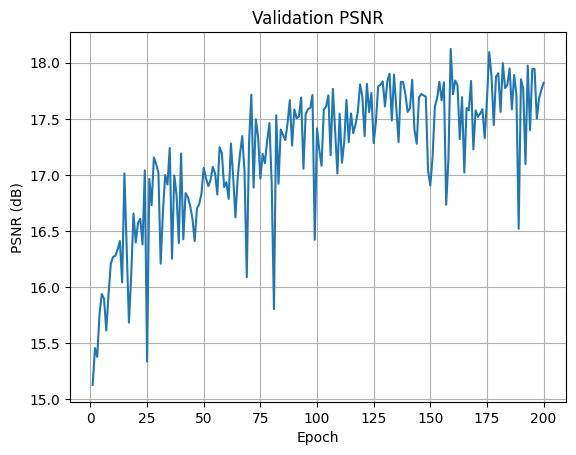

In [43]:
# Validation PSNR
plt.plot(epochs, val_psnr)
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title('Validation PSNR')
plt.grid(True)
plt.savefig('validation_psnr.png', dpi=300, bbox_inches='tight')

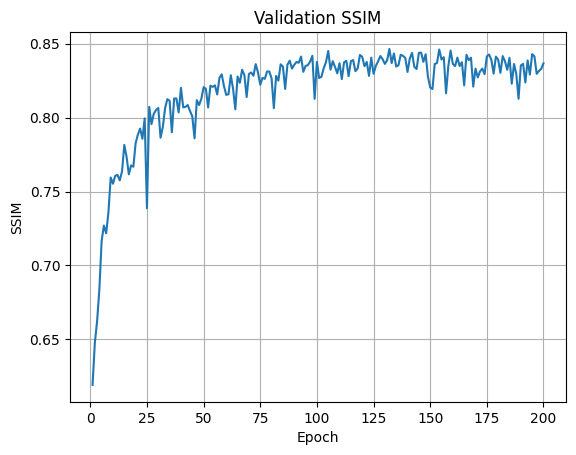

In [44]:
# Validation SSIM

plt.plot(epochs, val_ssim)
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.title('Validation SSIM')
plt.grid(True)
plt.savefig('validation_ssim.png', dpi=300, bbox_inches='tight')

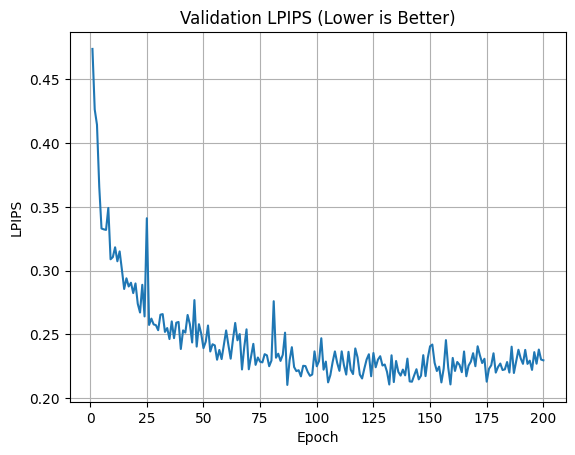

In [45]:
# Validation LPIPS
plt.plot(epochs, val_lpips)
plt.xlabel('Epoch')
plt.ylabel('LPIPS')
plt.title('Validation LPIPS (Lower is Better)')
plt.grid(True)
plt.savefig('validation_lpips.png', dpi=300, bbox_inches='tight')

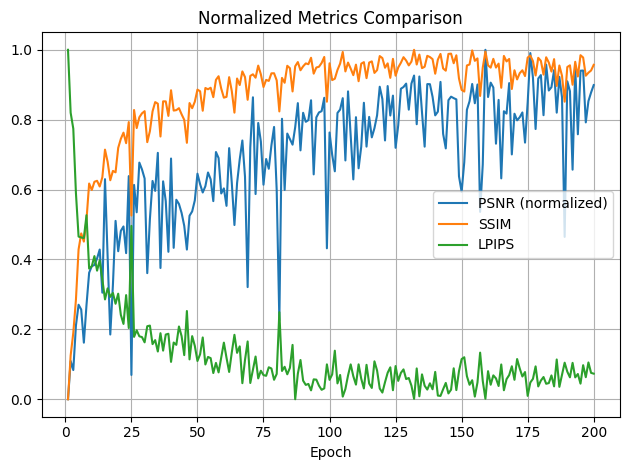

In [47]:
# Combined Metrics
val_psnr_norm = (np.array(val_psnr)-np.min(val_psnr))/(np.max(val_psnr)-np.min(val_psnr))
val_ssim_norm = (np.array(val_ssim)-np.min(val_ssim))/(np.max(val_ssim)-np.min(val_ssim))
val_lpips_norm = (np.array(val_lpips)-np.min(val_lpips))/(np.max(val_lpips)-np.min(val_lpips))

plt.plot(epochs, val_psnr_norm, label='PSNR (normalized)')
plt.plot(epochs, val_ssim_norm, label='SSIM')
plt.plot(epochs, val_lpips_norm, label='LPIPS')
plt.xlabel('Epoch')
plt.title('Normalized Metrics Comparison')
plt.legend(loc='right')
plt.grid(True)

plt.tight_layout()
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()